In [20]:
# !python -m pip install nibabel
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

### Import data

In [21]:
nib_images = []
images = np.zeros((10, 182, 218, 182))
for i in range(1, 11):
    nib_images.append(nib.load('data/original/sub-TELL01'+format(i, '02d')+'_T1w_brain_homog_mni.nii.gz'))
    images[i-1] = nib_images[-1].get_fdata()


### Normalize $\in [0,1]$

In [22]:
for image in images:
    image -= np.min(image)
    image /= np.max(image)

In [23]:
for image in images:
    print(np.min(image), np.max(image))

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


In [24]:
masks = (images != 0)

### Synthetic T3 MRI's

In [25]:
var = 0.003
sigma = var**0.5
noisy_images = images + np.random.normal(0, sigma, images.shape)
for noisy_image in noisy_images:
    noisy_image -= np.min(noisy_image)
    noisy_image /= np.max(noisy_image)

In [26]:
# Re skullstripping
noisy_images[~masks] = 0

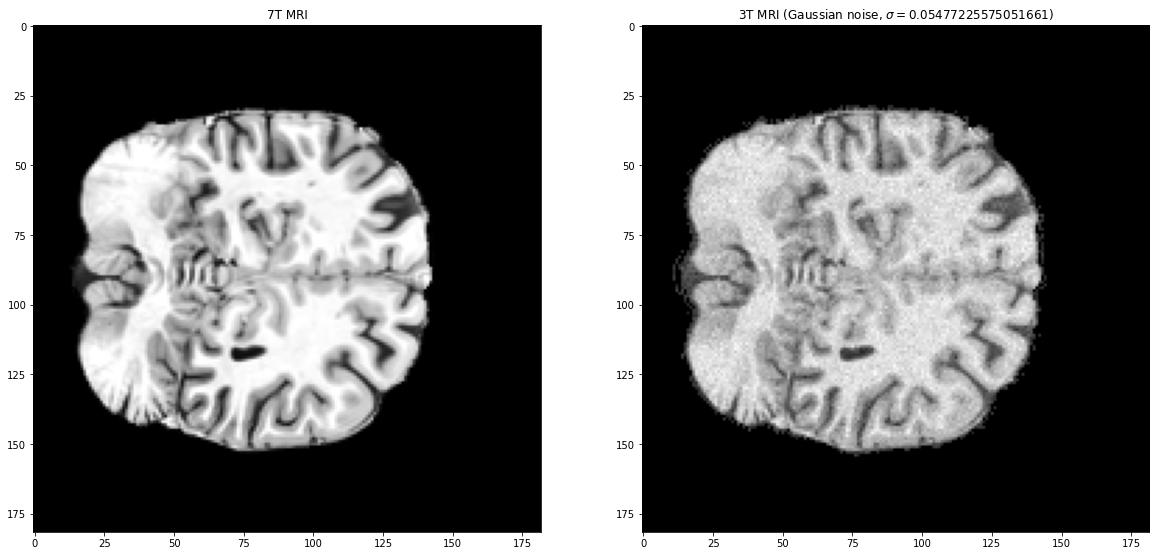

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
depth = 150
ax1.imshow(images[0, :, depth, :], cmap='gray')
ax1.set_title('7T MRI')
ax2.imshow(noisy_images[0, :, depth, :], cmap='gray')
ax2.set_title(f'3T MRI (Gaussian noise, $\sigma=${sigma})')
plt.show()

### Histogram matching

In [28]:
bins = np.linspace(0, 1, num=100, endpoint=False)

In [29]:
def compute_histogram(mri, bins, mask=None):
    return np.histogram(mri[mask], bins=bins) if mask is not None else np.histogram(mri[mri > 0], bins=bins)

def plot_histogram(hist, bins, label=None, ax = None):
    hist = np.insert(hist, 0, hist[0])
    if ax is None:
        plt.plot(bins, hist, drawstyle='steps', label=label)
    else:
        ax.plot(bins, hist, drawstyle='steps', label=label) 

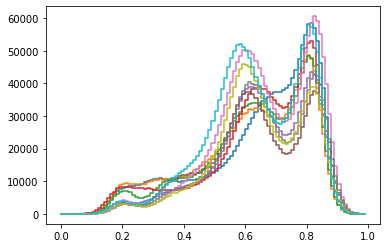

In [30]:
for noisy_image, mask in zip(noisy_images, masks):
    hist, bins = compute_histogram(noisy_image, bins, mask)
    plot_histogram(hist, bins)
plt.show()

In [31]:
# !python -m pip install -U scikit-image
from skimage.exposure import match_histograms

In [32]:
norm_noisy_images = np.zeros(images.shape) # normalized noisy images
norm_noisy_images[0] = noisy_images[0]
for i in range(len(norm_noisy_images[1:])):
    norm_noisy_images[i + 1][masks[i + 1]] = match_histograms(noisy_images[i + 1][masks[i + 1]].ravel(), noisy_images[0][masks[0]].ravel())

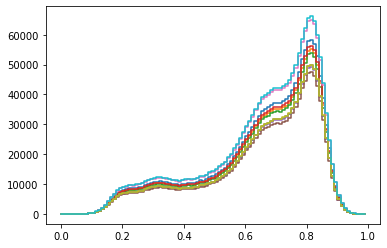

In [33]:
for norm_noisy_image, mask in zip(norm_noisy_images, masks):
    hist, bins = compute_histogram(norm_noisy_image, bins, mask)
    plot_histogram(hist, bins)
plt.show()

### Save the synthetic 3T MRIs

In [34]:
for i, nnim in enumerate(norm_noisy_images):
    nib_nnim = nib.Nifti1Image(nnim, nib_images[i].affine)
    nib.save(nib_nnim, 'data/dataset3/synthetic_3T_MRI_sub'+format(i + 1, '02d')+'.nii.gz')

### Histogram-match the original 7T MRIs too

In [35]:
bins = np.linspace(0, 1, num=50, endpoint=False)

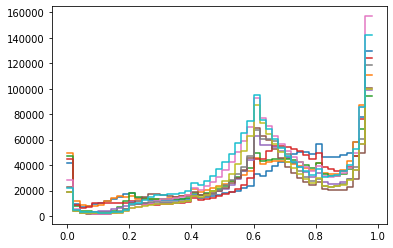

In [36]:
for image, mask in zip(images, masks):
    hist, bins = compute_histogram(image, bins, mask)
    plot_histogram(hist, bins)
plt.show()

In [37]:
norm_original_images = np.zeros(images.shape)
norm_original_images[0] = images[0]
for i in range(len(norm_original_images[1:])):
    norm_original_images[i + 1][masks[i + 1]] = match_histograms(images[i + 1][masks[i + 1]].ravel(), images[0][masks[0]].ravel())

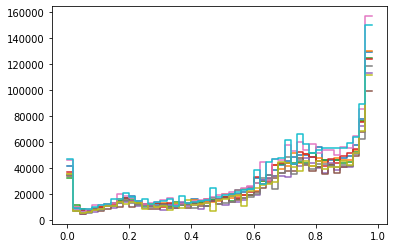

In [38]:
for norm_original_image, mask in zip(norm_original_images, masks):
    hist, bins = compute_histogram(norm_original_image, bins, mask)
    plot_histogram(hist, bins)
plt.show()

In [39]:
for i, noim in enumerate(norm_original_images):
    nib_noim = nib.Nifti1Image(noim, nib_images[i].affine)
    nib.save(nib_noim, 'data/dataset3/normalized_7T_MRI_sub'+format(i + 1, '02d')+'.nii.gz')